### Data Loading




In [1]:
#title Load Data Cifar10

import torch
import torchvision
import time
import random

use_gpu = torch.cuda.is_available()

# Load and transform data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

# preload

train_data = [ sample for sample in trainloader ]
test_data  = [ sample for sample in testloader  ]

100%|██████████| 170498071/170498071 [00:03<00:00, 43630031.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Data Visualization

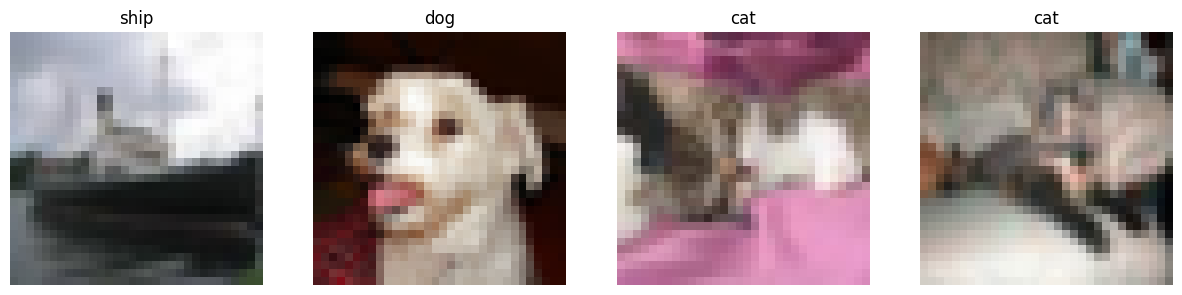

In [2]:
# visualize data with labels

import matplotlib.pyplot as plt
import numpy as np

# get classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)).astype(np.float32)
# get some random training images

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for image, i in zip(images, range(4)):

    # show images
    image = imshow(image)
    axs[i].imshow(image)
    axs[i].set_title(classes[labels[i]])
    axs[i].axis('off')


In [3]:
# Classification model ResNet18 based

import torch.nn as nn

class ClassificationNet(nn.Module):

    def __init__(self, features=16, num_layers=4, img_size=32):
        super(ClassificationNet, self).__init__()

        # define layers
        layers = []

        down_factor = 1

        # first layer
        layers.append(nn.Conv2d(3, features, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(features))

        # hidden layers
        for _ in range(num_layers):
            layers.append(nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            down_factor *= 2

        layers.append(nn.Flatten())

        final_size = int(img_size / down_factor)

        # output layer
        layers.append(nn.Linear(features * final_size * final_size, 10))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [4]:
model = ClassificationNet()

In [5]:
criterion = nn.CrossEntropyLoss()

In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()

  def __str__(self):
    return f"{self.avg}"

  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count




In [8]:
# top1 accuracy
def accuracy(output, target, topk=(1,)):
    '''Computes the accuracy over the k top predictions for the specified values of k'''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))

        return res

In [9]:

def validate(test_loader, model, criterion):
    model.eval()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(test_loader):
        data_time.update(time.time() - end)

        if use_gpu:
            image, label = image.cuda(), label.cuda()

        output = model(image)
        loss = criterion(output, label)
        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()
        top1.update(prec1, image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print('Test: \t'
          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
          'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
          'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
          'Accuracy {top1.val:.3f} ({top1.avg:.3f})'.format(
            batch_time=batch_time, data_time=data_time, loss=losses, top1=top1))


In [10]:
def train(train_loader, model, criterion, epoch):
    random.shuffle(train_loader)

    print('Starting training epoch {}'.format(epoch))
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()

        data_time.update(time.time() - end)

        if use_gpu:
            image, label = image.cuda(), label.cuda()

        with torch.cuda.amp.autocast(dtype=torch.float16):
          output = model(image)
          loss = criterion(output, label)

        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()

        top1.update(prec1, image.size(0))


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0:

            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {top1.val:.3f} ({top1.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1))



In [11]:
# Move model and loss function to GPU

if use_gpu:
  criterion = criterion.cuda()
  model = model.cuda()

In [12]:
# train model for 1000 epochs

epochs = 20

for epoch in range(epochs):

    train(train_data, model, criterion, epoch)

    with torch.no_grad():
        validate(test_data, model, criterion)



Starting training epoch 0
Epoch: [0][0/98]	Time 6.902 (6.902)	Data 0.000 (0.000)	Loss 2.3034 (2.3034)	Accuracy 9.180 (9.180)
Epoch: [0][50/98]	Time 0.013 (0.150)	Data 0.000 (0.000)	Loss 2.1285 (2.2104)	Accuracy 36.914 (26.624)
Test: 	Time 0.015 (0.019)	Data 0.000 (0.000)	Loss 2.0467 (2.0654)	Accuracy 45.791 (43.050)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.015 (0.015)	Data 0.000 (0.000)	Loss 2.0628 (2.0628)	Accuracy 44.531 (44.531)
Epoch: [1][50/98]	Time 0.013 (0.013)	Data 0.000 (0.000)	Loss 1.9910 (2.0081)	Accuracy 51.758 (49.039)
Test: 	Time 0.013 (0.018)	Data 0.000 (0.000)	Loss 1.9449 (1.9530)	Accuracy 54.592 (53.340)
Starting training epoch 2
Epoch: [2][0/98]	Time 0.016 (0.016)	Data 0.001 (0.001)	Loss 1.9668 (1.9668)	Accuracy 52.344 (52.344)
Epoch: [2][50/98]	Time 0.013 (0.013)	Data 0.000 (0.000)	Loss 1.9496 (1.9225)	Accuracy 52.734 (56.679)
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.9310 (1.9277)	Accuracy 53.827 (55.120)
Starting training epoch 3
Epoch: [3][0/98]